# CASM Visibility Analysis
This notebook analyzes the visibility simulation results generated by the time-series simulation.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from astropy.time import Time
from datetime import datetime
import pytz

In [113]:
# 1. Find the latest results directory
results_dirs = sorted(glob.glob("results_*"))
if not results_dirs:
    raise FileNotFoundError("No results directories found!")
latest_dir = results_dirs[-1]
print(f"Analyzing results from: {latest_dir}")

Analyzing results from: results_20251213_1723_to_20251215_1723


In [118]:
latest_dir = "/home/advait/research/casm/vis-modelling/results_20251213_1723_to_20251215_1723"

In [119]:
# 2. Load all visibility files and extract Source Data
vis_files = sorted(glob.glob(os.path.join(latest_dir, "visibilities", "*.npz")))
print(f"Found {len(vis_files)} visibility files")

data_list = []
times = []
sun_alts = []

# Assuming baselines and freqs are constant, load them from first file
first_data = np.load(vis_files[0])
baselines = first_data['baselines']
frequencies = first_data['frequencies']
baseline_pairs = first_data['baseline_pairs']

# Extract indices for the 3 test baselines
idx_auto = 0
idx_ew = 1 
idx_ns = 2

srcs = {}
srcs['Cas A'] = {'alt': [], 'az': []}
srcs['Cyg A'] = {'alt': [], 'az': []}
srcs['Tau A'] = {'alt': [], 'az': []}
srcs['Sun'] = {'alt': [], 'az': []}

pst = pytz.timezone('US/Pacific')

for f in vis_files:
    d = np.load(f)
    # Shape: (n_baselines, n_freq, 2, 2)
    vis = d['visibilities']
    t_iso = str(d['time_obs'])
    t_pst = Time(t_iso).to_datetime(timezone=pst)
    
    data_list.append(vis)
    times.append(t_pst)
    
    # Extract Source Altitudes
    src_names = d['source_names']
    src_alt = d['source_alt']
    
    for src in srcs.keys():

        src_idx = np.where(src_names == src)[0][0]
        srcs[src]['alt'].append(src_alt[src_idx])
        srcs[src]['az'].append(src_alt[src_idx])


# Stack into arrays
vis_array = np.array(data_list)
sun_alts = np.array(sun_alts)
print(f"Data shape: {vis_array.shape}")

Found 192 visibility files
Data shape: (192, 3, 3, 2, 2)


In [120]:
t_iso

'2025-12-16 01:08:23.396'

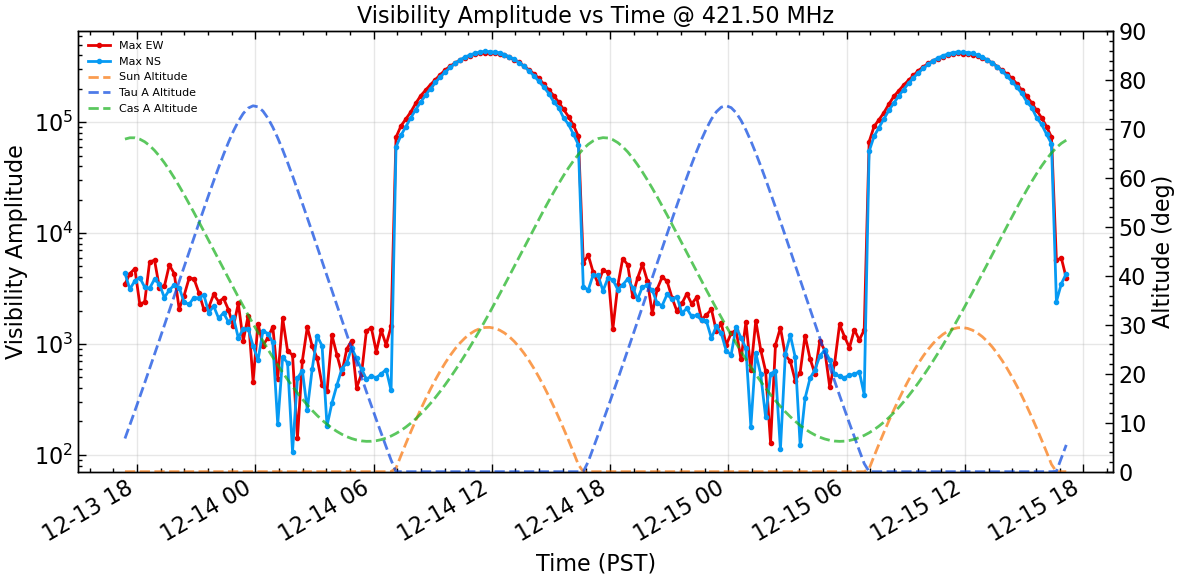

In [121]:
# 3. Plot Amplitude vs Time with Sun Altitude
mid_freq_idx = len(frequencies) // 2
freq_mhz = frequencies[mid_freq_idx]

amp_auto = np.abs(vis_array[:, idx_auto, mid_freq_idx, 0, 0])
amp_ew = np.abs(vis_array[:, idx_ew, mid_freq_idx, 0, 0])
amp_ns = np.abs(vis_array[:, idx_ns, mid_freq_idx, 0, 0])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Visibilities on Left Axis
# ax1.plot(times, amp_auto, label=f'Auto (Ant 0)', marker='.', color='C0')
ax1.plot(times, amp_ew, label=f'Max EW', marker='.', color='xkcd:red')
ax1.plot(times, amp_ns, label=f'Max NS', marker='.', color='xkcd:azure')
ax1.set_xlabel('Time (PST)')
ax1.set_ylabel('Visibility Amplitude', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(times, srcs['Sun']['alt'], label='Sun Altitude', color='xkcd:orange', linestyle='--', linewidth=2, alpha=0.7)
ax2.plot(times, srcs['Tau A']['alt'], label='Tau A Altitude', color='xkcd:blue', linestyle='--', linewidth=2, alpha=0.7)
ax2.plot(times, srcs['Cas A']['alt'], label='Cas A Altitude', color='xkcd:green', linestyle='--', linewidth=2, alpha=0.7)
# ax2.plot(times, srcs['Cyg A']['alt'], label='Cyg A Altitude', color='xkcd:red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_ylabel('Altitude (deg)')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 90)  # Standard horizon to zenith

# Valid time formatting
fig.autofmt_xdate()

plt.title(f'Visibility Amplitude vs Time @ {freq_mhz:.2f} MHz')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize = 8)

plt.tight_layout()
plt.show()

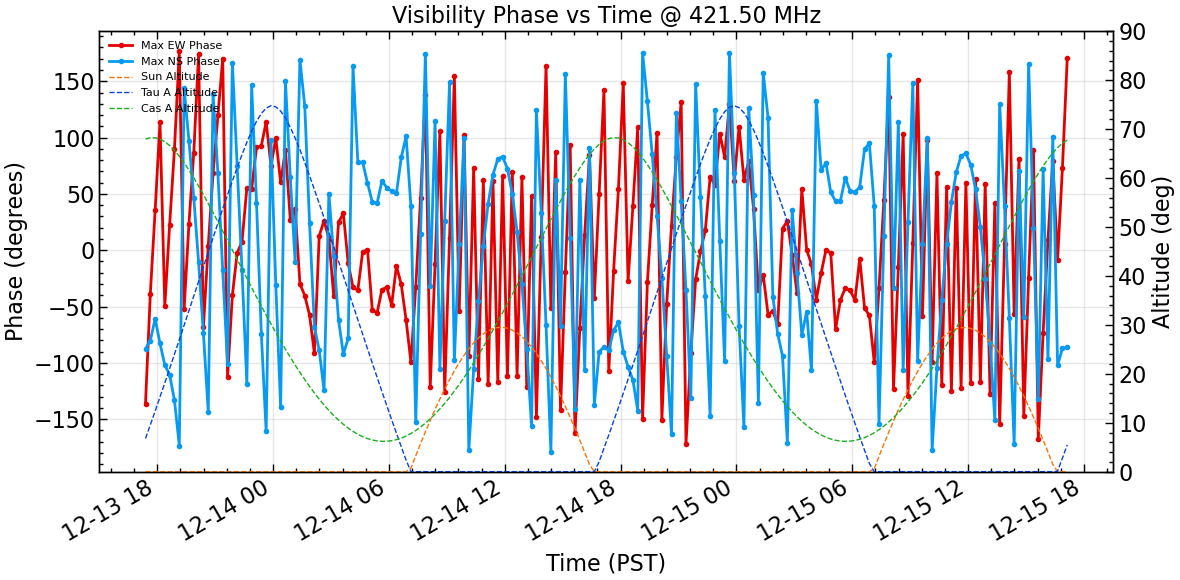

In [122]:
# 4. Plot Phase vs Time with Sun Altitude
phase_ew = np.angle(vis_array[:, idx_ew, mid_freq_idx, 0, 0])
phase_ns = np.angle(vis_array[:, idx_ns, mid_freq_idx, 0, 0])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Phases
ax1.plot(times, np.degrees(phase_ew), label='Max EW Phase', marker='.', color='xkcd:red', lw = 2)
ax1.plot(times, np.degrees(phase_ns), label='Max NS Phase', marker='.', color='xkcd:azure', lw = 2)
ax1.set_xlabel('Time (PST)')
ax1.set_ylabel('Phase (degrees)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(times, srcs['Sun']['alt'], label='Sun Altitude', color='xkcd:orange', linestyle='--', linewidth=1, alpha=1)
ax2.plot(times, srcs['Tau A']['alt'], label='Tau A Altitude', color='xkcd:blue', linestyle='--', linewidth=1, alpha=1)
ax2.plot(times, srcs['Cas A']['alt'], label='Cas A Altitude', color='xkcd:green', linestyle='--', linewidth=1, alpha=1)
ax2.set_ylabel('Altitude (deg)')

ax2.tick_params(axis='y')
ax2.set_ylim(0, 90)

fig.autofmt_xdate()
plt.title(f'Visibility Phase vs Time @ {freq_mhz:.2f} MHz')

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [175]:
latest_dir = "results_20251213_1310_to_20251213_1510"

In [176]:
# 2. Load all visibility files and extract Source Data
vis_files = sorted(glob.glob(os.path.join(latest_dir, "visibilities", "*.npz")))
print(f"Found {len(vis_files)} visibility files")

data_list = []
times = []
sun_alts = []

# Assuming baselines and freqs are constant, load them from first file
first_data = np.load(vis_files[0])
baselines = first_data['baselines']
frequencies = first_data['frequencies']
baseline_pairs = first_data['baseline_pairs']

# Extract indices for the 3 test baselines
idx_auto = 0
idx_ew = 1 
idx_ns = 2

srcs = {}
srcs['Cas A'] = {'alt': [], 'az': []}
srcs['Cyg A'] = {'alt': [], 'az': []}
srcs['Tau A'] = {'alt': [], 'az': []}
srcs['Sun'] = {'alt': [], 'az': []}

pst = pytz.timezone('US/Pacific')

for f in vis_files:
    d = np.load(f)
    # Shape: (n_baselines, n_freq, 2, 2)
    vis = d['visibilities']
    t_iso = str(d['time_obs'])
    t_pst = Time(t_iso).to_datetime(timezone=pst)
    
    data_list.append(vis)
    times.append(t_pst)
    
    # Extract Source Altitudes
    src_names = d['source_names']
    src_alt = d['source_alt']
    
    for src in srcs.keys():

        src_idx = np.where(src_names == src)[0][0]
        srcs[src]['alt'].append(src_alt[src_idx])
        srcs[src]['az'].append(src_alt[src_idx])


# Stack into arrays
vis_array = np.array(data_list)
sun_alts = np.array(sun_alts)
print(f"Data shape: {vis_array.shape}")

Found 1200 visibility files
Data shape: (1200, 3, 100, 2, 2)


/tmp/ipykernel_528769/3103540968.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


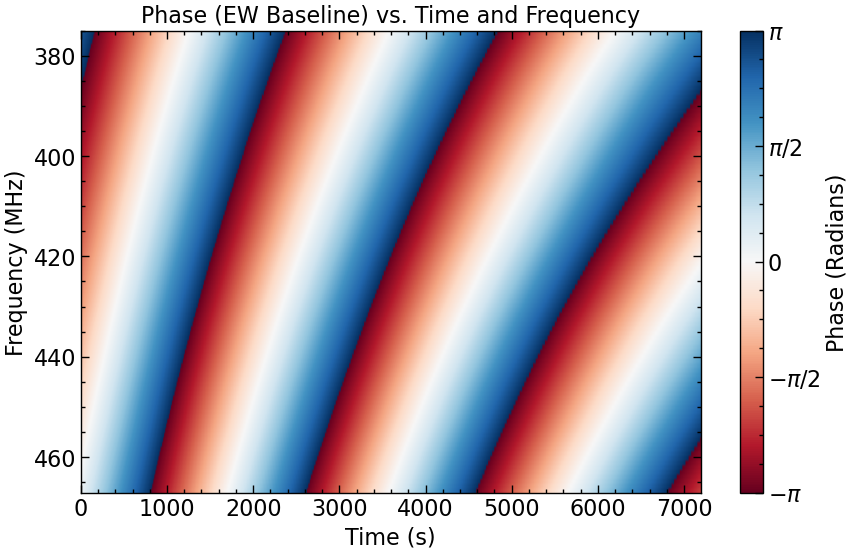

In [177]:
# 4. Plot Phase vs Time with Sun Altitude
phase_ew = np.angle(vis_array[:, idx_ew, :, 0, 0])
phase_ns = np.angle(vis_array[:, idx_ns, :, 0, 0])

# time axis has 0.1 mins per step, convert to s
time_axis = np.arange(vis_array.shape[0]) * 60 * 0.1

# freq axis is from 375 to 468 MHz with 100 channels
frequency_axis = np.arange(vis_array.shape[2]) * (468 - 375) / 100 + 375

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stored the output of imshow in 'im' to use it for the colorbar
im = ax1.imshow(
    phase_ew.T, 
    aspect='auto', 
    cmap='RdBu', 
    extent=[time_axis[0], time_axis[-1], frequency_axis[-1], frequency_axis[0]], # Flipped y-axis for proper imshow orientation
    vmin=-np.pi,
    vmax=np.pi
)

ax1.set_ylabel('Frequency (MHz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Phase (EW Baseline) vs. Time and Frequency')


# Add Colorbar (USER REQUEST)
cbar = plt.colorbar(im, ax=ax1, orientation='vertical', pad=0.05)
cbar.set_label('Phase (Radians)')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])


plt.legend()
plt.show()

# Plot Phases


/tmp/ipykernel_528769/2252209996.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


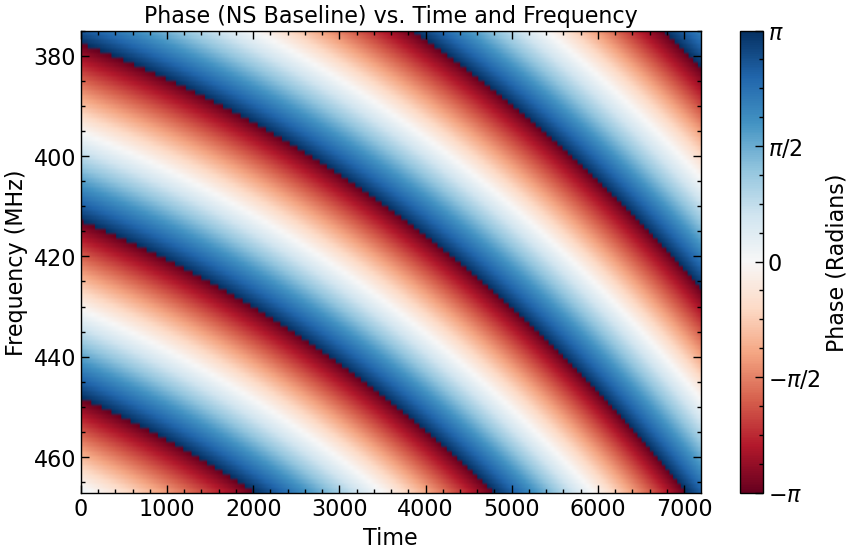

In [178]:
# 4. Plot Phase vs Time with Sun Altitude
phase_ew = np.angle(vis_array[:, idx_ew, :, 0, 0])
phase_ns = np.angle(vis_array[:, idx_ns, :, 0, 0])

# time axis has 0.1 mins per step, convert to s
time_axis = np.arange(vis_array.shape[0]) * 60 * 0.1

# freq axis is from 375 to 468 MHz with 100 channels
frequency_axis = np.arange(vis_array.shape[2]) * (468 - 375) / 100 + 375

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stored the output of imshow in 'im' to use it for the colorbar
im = ax1.imshow(
    phase_ns.T, 
    aspect='auto', 
    cmap='RdBu', 
    extent=[time_axis[0], time_axis[-1], frequency_axis[-1], frequency_axis[0]], # Flipped y-axis for proper imshow orientation
    vmin=-np.pi,
    vmax=np.pi
)

ax1.set_ylabel('Frequency (MHz)')
ax1.set_xlabel('Time')
ax1.set_title('Phase (NS Baseline) vs. Time and Frequency')


# Add Colorbar (USER REQUEST)
cbar = plt.colorbar(im, ax=ax1, orientation='vertical', pad=0.05)
cbar.set_label('Phase (Radians)')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])


plt.legend()
plt.show()

# Plot Phases


Target: 430.0 MHz -> Actual: 430.42 MHz (Index 59)
Target: 485.0 MHz -> Actual: 468.00 MHz (Index 99)


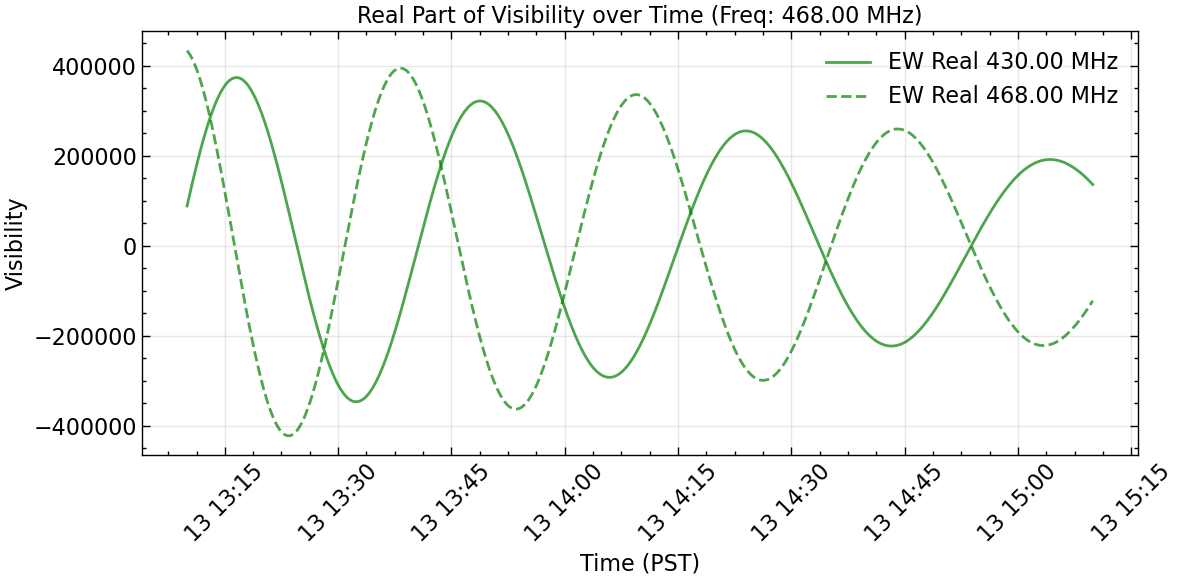

In [174]:
# Find indices for 430 MHz and 485 MHz
target_freqs = [430.0, 485.0]
freq_indices = []

for target in target_freqs:
    # Find index of frequency closest to target
    idx = (np.abs(frequencies - target)).argmin()
    actual_freq = frequencies[idx]
    freq_indices.append((idx, actual_freq))
    print(f"Target: {target} MHz -> Actual: {actual_freq:.2f} MHz (Index {idx})")

# Plotting Loop
pol_idx_1 = 0 # XX polarization
pol_idx_2 = 0 # XX polarization
plt.figure(figsize=(12, 6))
# for f_idx, f_val in freq_indices:
    
# East-West Baseline
plt.plot(times, vis_array[:, idx_ew, freq_indices[0][0], pol_idx_1, pol_idx_2].real, 
            label='EW Real 430.00 MHz', color='green', alpha=0.7)

plt.plot(times, vis_array[:, idx_ew, freq_indices[1][0], pol_idx_1, pol_idx_2].real, 
            label='EW Real 468.00 MHz', color='green', ls = "--", alpha=0.7)


plt.xlabel('Time (PST)')
plt.ylabel('Visibility')
plt.title(f'Real Part of Visibility over Time (Freq: {f_val:.2f} MHz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Target: 430.0 MHz -> Actual: 430.42 MHz (Index 59)
Target: 485.0 MHz -> Actual: 468.00 MHz (Index 99)


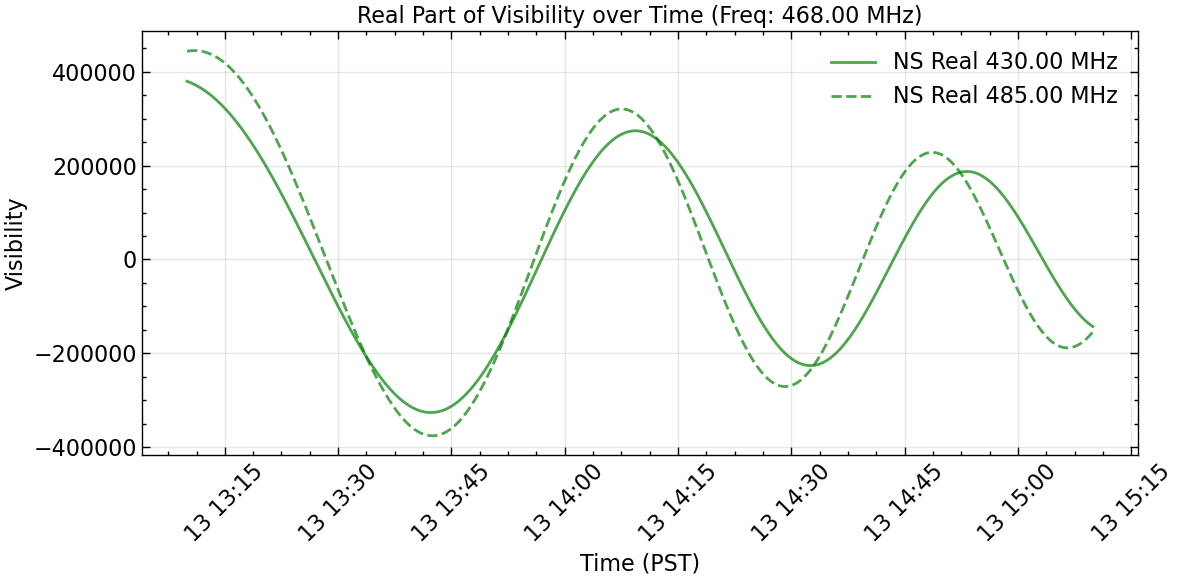

In [173]:
# Find indices for 430 MHz and 485 MHz
target_freqs = [430.0, 485.0]
freq_indices = []

for target in target_freqs:
    # Find index of frequency closest to target
    idx = (np.abs(frequencies - target)).argmin()
    actual_freq = frequencies[idx]
    freq_indices.append((idx, actual_freq))
    print(f"Target: {target} MHz -> Actual: {actual_freq:.2f} MHz (Index {idx})")

# Plotting Loop
pol_idx_1 = 0 # XX polarization
pol_idx_2 = 0 # XX polarization
plt.figure(figsize=(12, 6))
# for f_idx, f_val in freq_indices:
    
# East-West Baseline
plt.plot(times, vis_array[:, idx_ns, freq_indices[0][0], pol_idx_1, pol_idx_2].real, 
            label='NS Real 430.00 MHz', color='green', alpha=0.7)

plt.plot(times, vis_array[:, idx_ns, freq_indices[1][0], pol_idx_1, pol_idx_2].real, 
            label='NS Real 485.00 MHz', color='green', ls = "--", alpha=0.7)


plt.xlabel('Time (PST)')
plt.ylabel('Visibility')
plt.title(f'Real Part of Visibility over Time (Freq: {f_val:.2f} MHz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [169]:
freq_indices[1][0]

np.int64(99)

In [163]:
times[-1]

datetime.datetime(2025, 12, 13, 15, 9, 54, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>)

In [164]:
times[0]

datetime.datetime(2025, 12, 13, 13, 10, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>)